# Introduction to Options
#### Lucien Chen

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import norm
import yfinance as yf
import ipywidgets as widgets
from IPython.display import display
plt.style.use('ggplot')

### What are Options?
 - Options are financial derivatives (FDs), i.e futures, forward contracts, swaps, etc., that give a buyer the right, but not an obligation, to buy a sell a security at a certain price, known as the strike, at a certain date
 - Call options are an agreement to buy shares of stock (usually in quantities of 100) at a certain price by a certain date
 - Put options are an agreement to sell shares of a stock (usually in quantities of 100) at a certain price by a certain date
 - American vs. European options: European options can only be exercised on the expiration date where as American options can be exercised anytime before; these are considered vanilla
 - Options and other FDs are commonly used for hedging, speculation, arbitrage and C-suite compensation
 - Hedgers aim to reduce risk, speculators aim to profit from betting on future movements in the underlying, and arbitrageurs aim to profit from the bid-ask spread on options

### Definitions
- *Derivative* - a financial instrument whose value depends on one (or more) underlying variables
- *Strike* - the price fixed by the options contract
- *Maturity* - also known as the expiration date, the day the contract expires
- *Premium* - price you pay per share for an option broken down into intrinsic value and extrinsic, or time, value
- *Spot* - the price of an asset that can be sold or bought immediately, the current trading price
- *Intrinsic value* - the positive difference between the spot and the strike (call); the positive difference between the strike and the spot (put)
- *Time value* - value of an option based on it's DTE (days to expiration) due to the possibility of an increase in instrinsic value

In [7]:
cols = ['European Call', 'European Put', 'American Call', 'American Put']
spot = ['+', '-', '+', '-']
strike = ['-', '+', '-', '+']
maturity = ['?', '?', '+', '+']
vega = ['+', '+', '+', '+']
rho = ['+', '-', '+', '-']
dividends = ['-', '+', '-', '+']
option_properties = pd.DataFrame(columns = cols)
option_properties.loc['Current Price'] = spot
option_properties.loc['Strike'] = strike
option_properties.loc['Time to Expiration'] = maturity
option_properties.loc['Volatility'] = vega
option_properties.loc['Risk-free Rate'] = rho
option_properties.loc['Future Dividends'] = dividends
option_properties

,European Call,European Put,American Call,American Put
Current Price,+,-,+,-
Strike,-,+,-,+
Time to Expiration,?,?,+,+
Volatility,+,+,+,+
Risk-free Rate,+,-,+,-
Future Dividends,-,+,-,+


###### **Assuming variables increase*

__*+*__ represents an increase in value

__*-*__ represents a decrease in value

__*?*__ represents an ambiguous change

### More formally, *The Greeks*

- $\delta$, the derivative of an option's price with respect to the price of the asset $\frac{\partial \pi}{\partial S}$

- $\gamma$, the second derivative of an option's price with respect to the price of an asset $\frac{\partial^2 \pi}{\partial^2 S}$

- $\theta$, the derivative of an option's price with respect to the passage of time, also known as time decay

- $\nu$, the derivative of an option's price with respect to the volatility of an asset $\frac{\partial \pi}{\partial \sigma}$

where $\pi$ represets the price of the option, $S$ represents the price of the asset and $\sigma$ represents volatilty


### In Practice

Given that we've roughly covered the basics of options, we can take a dive into a toy example to see how they work in practice.

For example, let's say that Nicholas buys 100 shares of TSLA at $200/share. 

He believes in the company long term but is concerned about volatility and wants to hedge his risk. He buys a put option ATM with an expiration of March 15, 2024, for $42. 

One year later, TSLA is trading at $100/share and now Nicholas has an unrealized loss of $100/share, but his put option now has an intrinsic value of $100. 

Whereas he would have normally lost $10,000 (-$100 * 100), he only lost $4,200 (the price he paid for the option). 


In [75]:
def profit(S):
    N = 100
    P = 200
    cost_basis = P * N
    value = S * N
    put_value = max(-42, P - S - 42)
    return value + put_value*100 - cost_basis

In [76]:
profits = pd.DataFrame(np.vectorize(profit)(np.arange(50, 301))).rename(columns={0: 'Profit'})
colors = ['red' if x <= 0 else 'green' for x in profits["Profit"]]

Text(0.5, 0, 'TSLA Trading Price ($)')

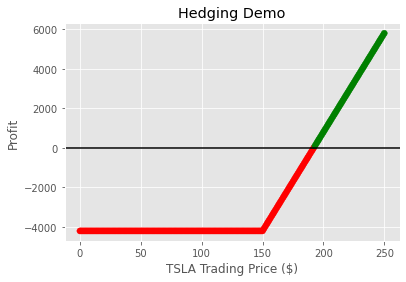

In [92]:
plt.scatter(profits.index, profits["Profit"], c=colors)
plt.axhline(y=0, color='black')
plt.title('Hedging Demo')
plt.ylabel('Profit')
plt.xlabel('TSLA Trading Price ($)')

In [ ]:
rf = yf.Ticker('^IRX').history().Close.iloc[-1] / 100 

### Options Pricing

The Black-Scholes option formula is a formula that is commonly used to price *European* options.

Assumptions:
 - Dividends are not paid out over the course of the options life
 - Markets are random
 - Zero transaction costs
 - Risk-free rate and volatility are constant
 - Returns are normally distributed
 - Option can only be exercised at expiration
 
$$C=N(d_1)S_t - N(d_2)Ke^{-rt}$$
$$P=N(d_1)K - N(d_2)S_te^{-rt}$$
$$d_1=\frac{\ln{\frac{S_t}{K}} + (r + \frac{\sigma^2}{2})t}{\sigma\sqrt{t}}$$
$$d_2=d_1 - \sigma\sqrt{t}$$

C = call option price

P = put option price

N = cumulative distribution function (cdf) of the normal distribution

$S_t$ = spot price of the underlying

K = strike price

r = risk-free rate

t = time to expiration

$\sigma$ = volatility of the underlying

In [ ]:
def bs_call(S, K, r, t, sigma):
    N = norm.cdf
    d1 = (np.log(S/K) + ((r + (sigma**2 / 2)) * t)) / (sigma * np.sqrt(t))
    d2 = d1 - (sigma * np.sqrt(t))
    return N(d1) * S - N(d2) * K * (np.e ** (-r * t))

def bs_put(S, K, r, t, sigma):
    N = norm.cdf
    d1 = (np.log(S/K) + ((r + (sigma**2 / 2)) * t)) / (sigma * np.sqrt(t))
    d2 = d1 - (sigma * np.sqrt(t))
    return N(d1) * K - N(d2) * S * (np.e ** (-r * t))

In [ ]:
def create_graph(K, r, t, sigma):
    S = np.arange(50, 151, 0.1)
    calls = [bs_call(s, K, r, t, sigma) for s in S]
    puts = [bs_put(s, K, r, t, sigma) for s in S]
    fig = plt.figure(figsize=(8,4))
    plt.plot(S, calls, label="Call Option Value")
    plt.plot(S, puts, label="Put Option Value")
    plt.xlabel("$S_0$")
    plt.ylabel("Value ($)")
    plt.title("Black-Scholes Pricing Demo")
    plt.legend()

In [ ]:
w = widgets.interact(create_graph, K=widgets.IntSlider(min=50, max=150), r=widgets.fixed(rf), t=widgets.IntSlider(min=1, max=365), sigma=widgets.FloatSlider(min = 0.05, max=1, step=0.05))
display(w)

interactive(children=(IntSlider(value=50, description='K', max=150, min=50), IntSlider(value=1, description='t…

<function __main__.create_graph(K, r, t, sigma)>

Sources: 
- investopedia.com
- *Options, Futures, and Other Derivatives (9th Edition), Hull*